In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

def load_peptide_data(data_path, max_sequences_per_class=25000):
    """
    Load peptide sequences from CSV files with comprehensive error handling and statistics
    """
    therapeutic_path = os.path.join(data_path, "Therapeutic data")
    non_therapeutic_path = os.path.join(data_path, "Non-Therapeutic data")
    
    sequences, labels = [], []
    file_stats = {}
    
    if not os.path.exists(therapeutic_path):
        print(f"Warning: {therapeutic_path} not found!")
        return [], [], {}
    
    if not os.path.exists(non_therapeutic_path):
        print(f"Warning: {non_therapeutic_path} not found!")
        return [], [], {}
    
    print("Loading therapeutic peptides...")
    therapeutic_total = 0
    for filename in os.listdir(therapeutic_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                if df.shape[1] >= 1:
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    # Validate and clean sequences
                    valid_seqs = []
                    for seq in seqs:
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 5 <= len(clean_seq) <= 200:
                            valid_seqs.append(clean_seq)
                    
                    # Limit sequences to prevent memory issues
                    if max_sequences_per_class and therapeutic_total + len(valid_seqs) > max_sequences_per_class:
                        remaining = max(0, max_sequences_per_class - therapeutic_total)
                        valid_seqs = valid_seqs[:remaining]
                    
                    sequences.extend(valid_seqs)
                    labels.extend([1] * len(valid_seqs))
                    therapeutic_total += len(valid_seqs)
                    file_stats[f"therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                    
                    if max_sequences_per_class and therapeutic_total >= max_sequences_per_class:
                        break
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total therapeutic sequences: {therapeutic_total}")
    
    print("\nLoading non-therapeutic peptides...")
    non_therapeutic_total = 0
    for filename in os.listdir(non_therapeutic_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(non_therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                if df.shape[1] >= 1:
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    # Validate and clean sequences
                    valid_seqs = []
                    for seq in seqs:
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 5 <= len(clean_seq) <= 200:
                            valid_seqs.append(clean_seq)
                    
                    # Limit sequences to prevent memory issues
                    if max_sequences_per_class and non_therapeutic_total + len(valid_seqs) > max_sequences_per_class:
                        remaining = max(0, max_sequences_per_class - non_therapeutic_total)
                        valid_seqs = valid_seqs[:remaining]
                    
                    sequences.extend(valid_seqs)
                    labels.extend([0] * len(valid_seqs))
                    non_therapeutic_total += len(valid_seqs)
                    file_stats[f"non_therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                    
                    if max_sequences_per_class and non_therapeutic_total >= max_sequences_per_class:
                        break
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total non-therapeutic sequences: {non_therapeutic_total}")
    print(f"Overall total: {len(sequences)} sequences")
    
    return sequences, labels, file_stats

def extract_comprehensive_features(sequences):
    """
    Extract comprehensive biochemical features from peptide sequences
    Returns enhanced feature set optimized for alternative model comparison
    """
    features = []
    feature_names = []
    
    print("Extracting comprehensive biochemical features...")
    
    for seq in tqdm(sequences, desc="Processing sequences"):
        seq_len = len(seq)
        feature_vector = []
        
        # 1. Basic sequence properties
        feature_vector.append(seq_len)
        
        # 2. Amino acid composition (20 features)
        aa_composition = {}
        for aa in 'ACDEFGHIKLMNPQRSTVWY':
            aa_composition[aa] = seq.count(aa) / seq_len
            feature_vector.append(aa_composition[aa])
        
        # 3. Amino acid group compositions
        hydrophobic = sum(seq.count(aa) for aa in 'AILMFWV') / seq_len
        polar = sum(seq.count(aa) for aa in 'NQST') / seq_len
        charged = sum(seq.count(aa) for aa in 'KRDEH') / seq_len
        aromatic = sum(seq.count(aa) for aa in 'FWY') / seq_len
        tiny = sum(seq.count(aa) for aa in 'ACSV') / seq_len
        small = sum(seq.count(aa) for aa in 'ABDHNT') / seq_len
        aliphatic = sum(seq.count(aa) for aa in 'ILV') / seq_len
        
        feature_vector.extend([hydrophobic, polar, charged, aromatic, tiny, small, aliphatic])
        
        # 4. Charge properties
        positive_charge = seq.count('K') + seq.count('R') + seq.count('H')
        negative_charge = seq.count('D') + seq.count('E')
        net_charge = positive_charge - negative_charge
        
        feature_vector.extend([
            positive_charge / seq_len,
            negative_charge / seq_len,
            net_charge / seq_len,
            abs(net_charge) / seq_len
        ])
        
        # 5. Structural features
        proline_content = seq.count('P') / seq_len
        glycine_content = seq.count('G') / seq_len
        cysteine_content = seq.count('C') / seq_len
        
        feature_vector.extend([proline_content, glycine_content, cysteine_content])
        
        # 6. Dipeptide composition (enhanced)
        dipeptide_freq = {}
        for i in range(len(seq)-1):
            dipeptide = seq[i:i+2]
            dipeptide_freq[dipeptide] = dipeptide_freq.get(dipeptide, 0) + 1
        
        # Top 15 most important dipeptides for therapeutic prediction
        important_dipeptides = ['AA', 'AC', 'AG', 'AL', 'AR', 'AS', 'AT', 'AV', 'AY', 'AW',
                               'KK', 'RR', 'LL', 'FF', 'WW']
        
        for dp in important_dipeptides:
            feature_vector.append(dipeptide_freq.get(dp, 0) / (seq_len - 1) if seq_len > 1 else 0)
        
        # 7. Hydrophobic moment (simplified)
        hydrophobic_values = {
            'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
            'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
            'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
            'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
        }
        
        hydrophobic_moment = 0
        for i, aa in enumerate(seq):
            if aa in hydrophobic_values:
                angle = i * 100 * np.pi / 180
                hydrophobic_moment += hydrophobic_values[aa] * np.exp(1j * angle)
        
        feature_vector.append(abs(hydrophobic_moment) / seq_len)
        
        # 8. Sequence complexity measures
        # Repeating patterns
        max_repeat = 1
        current_repeat = 1
        for i in range(1, seq_len):
            if seq[i] == seq[i-1]:
                current_repeat += 1
                max_repeat = max(max_repeat, current_repeat)
            else:
                current_repeat = 1
        
        feature_vector.append(max_repeat / seq_len)
        
        # Entropy (sequence diversity)
        entropy = -sum((count/seq_len) * np.log2(count/seq_len) 
                      for count in aa_composition.values() if count > 0)
        feature_vector.append(entropy)
        
        features.append(feature_vector)
    
    features_array = np.array(features, dtype=np.float32)
    print(f"Feature extraction completed: {features_array.shape[1]} features per sequence")
    
    return features_array

Using device: cuda
TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def create_advanced_dense_model(input_dim):
    """
    Create advanced dense neural network with batch normalization and regularization
    Optimized for therapeutic peptide prediction
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.15),
        
        Dense(16, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

def create_advanced_conv1d_model(input_dim):
    """
    Create advanced 1D CNN model with enhanced architecture
    Optimized for sequence-like feature patterns
    """
    model = Sequential([
        tf.keras.layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        
        Conv1D(64, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        
        Conv1D(32, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        
        Conv1D(16, 3, activation='relu', padding='same'),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

def create_lstm_model(input_dim):
    """
    Create LSTM model for sequence-based learning
    Optimized with reduced complexity for faster training
    """
    model = Sequential([
        tf.keras.layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

def get_model_complexity(model):
    """
    Get model complexity information
    """
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params
    }

In [3]:
print("=== ALTERNATIVE MODEL COMPARISON FOR THERAPEUTIC PEPTIDE PREDICTION ===\n")

# Create necessary directories
os.makedirs("../backend/models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

# Load data with correct relative paths
data_path = "../data"
sequences, labels, file_stats = load_peptide_data(data_path, max_sequences_per_class=15000)

# Display dataset statistics
if file_stats:
    print("\n📊 Dataset Statistics by File:")
    for file_key, count in file_stats.items():
        print(f"  {file_key}: {count:,} sequences")

print(f"\nFinal dataset: {len(sequences)} sequences")
print(f"Therapeutic: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"Non-therapeutic: {len(labels) - sum(labels)} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")

if len(sequences) == 0:
    print("ERROR: No valid sequences found!")
    print("Please check your data files in ../data/Therapeutic data/ and ../data/Non-Therapeutic data/")
    exit()

# Extract comprehensive features
features = extract_comprehensive_features(sequences)
print(f"Feature matrix shape: {features.shape}")

# Feature scaling
print("\n⚖️  Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Basic data quality validation (inline)
print("🔍 Validating data quality...")
labels_array = np.array(labels)

# Check for NaN values
nan_features = np.isnan(features_scaled).sum()
if nan_features > 0:
    print(f"⚠️  Warning: Found {nan_features} NaN values in features")
    features_scaled = np.nan_to_num(features_scaled)
    print("✅ NaN values replaced with zeros")
else:
    print("✅ No NaN values found")

# Check for infinite values
inf_features = np.isinf(features_scaled).sum()
if inf_features > 0:
    print(f"⚠️  Warning: Found {inf_features} infinite values in features")
    features_scaled = np.nan_to_num(features_scaled)
    print("✅ Infinite values replaced with finite values")
else:
    print("✅ No infinite values found")

# Check label distribution
unique_labels, counts = np.unique(labels_array, return_counts=True)
print(f"📊 Label distribution: {dict(zip(unique_labels, counts))}")

# Feature statistics
print(f"📈 Feature statistics:")
print(f"  - Feature matrix shape: {features_scaled.shape}")
print(f"  - Min value: {features_scaled.min():.6f}")
print(f"  - Max value: {features_scaled.max():.6f}")
print(f"  - Mean: {features_scaled.mean():.6f}")
print(f"  - Std: {features_scaled.std():.6f}")

# Sequence length statistics
seq_lengths = [len(seq) for seq in sequences]
print(f"🧬 Sequence length statistics:")
print(f"  - Min length: {min(seq_lengths)}")
print(f"  - Max length: {max(seq_lengths)}")
print(f"  - Mean length: {np.mean(seq_lengths):.1f}")
print(f"  - Median length: {np.median(seq_lengths):.1f}")

# Save scaler
with open("../backend/models/alternative_models_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved to ../backend/models/alternative_models_scaler.pkl")

print(f"\n🎯 Data preparation completed!")
print(f"  Feature matrix: {features_scaled.shape}")
print(f"  Total sequences: {len(sequences)}")
print(f"  Data quality validated ✅")
print(f"  Ready for model training!")

=== ALTERNATIVE MODEL COMPARISON FOR THERAPEUTIC PEPTIDE PREDICTION ===

Loading therapeutic peptides...
  ✓ Anti Bacterial Peptide_trimmed.csv: 6999 valid sequences
  ✓ Anti Cancer Peptide_trimmed.csv: 3999 valid sequences
  ✓ Anti Fungal Peptide_trimmed.csv: 4002 valid sequences
Total therapeutic sequences: 15000

Loading non-therapeutic peptides...
  ✓ Aspergillosis Peptide.csv: 1475 valid sequences
  ✓ Breast Cancer Peptide.csv: 347 valid sequences
  ✓ Candidiasis Peptide.csv: 3472 valid sequences
  ✓ Crohn’s Disease.csv: 7 valid sequences
  ✓ Cryptococcosis Peptide.csv: 2918 valid sequences
  ✓ E. coli Infections Peptide.csv: 5167 valid sequences
  ✓ Glioblastoma Peptide.csv: 31 valid sequences
  ✓ Leukemia Peptide.csv: 204 valid sequences
  ✓ Lung Cancer Peptide.csv: 370 valid sequences
  ✓ Melanoma Peptide.csv: 132 valid sequences
  ✓ MRSA Peptide.csv: 877 valid sequences
Total non-therapeutic sequences: 15000
Overall total: 30000 sequences

📊 Dataset Statistics by File:
  thera

Processing sequences: 100%|██████████| 30000/30000 [00:01<00:00, 25498.79it/s]


Feature extraction completed: 53 features per sequence
Feature matrix shape: (30000, 53)

⚖️  Scaling features...
🔍 Validating data quality...
✅ No NaN values found
✅ No infinite values found
📊 Label distribution: {0: 15000, 1: 15000}
📈 Feature statistics:
  - Feature matrix shape: (30000, 53)
  - Min value: -3.835976
  - Max value: 54.478451
  - Mean: 0.000000
  - Std: 1.000000
🧬 Sequence length statistics:
  - Min length: 5
  - Max length: 21
  - Mean length: 13.9
  - Median length: 14.0
✅ Scaler saved to ../backend/models/alternative_models_scaler.pkl

🎯 Data preparation completed!
  Feature matrix: (30000, 53)
  Total sequences: 30000
  Data quality validated ✅
  Ready for model training!


In [4]:
# Additional utility functions for robust model training
def validate_data_quality(X, y, sequences):
    """
    Validate data quality before training
    """
    print("🔍 Validating data quality...")
    
    # Check for NaN values
    nan_features = np.isnan(X).sum()
    if nan_features > 0:
        print(f"⚠️  Warning: Found {nan_features} NaN values in features")
        X = np.nan_to_num(X)
        print("✅ NaN values replaced with zeros")
    
    # Check for infinite values
    inf_features = np.isinf(X).sum()
    if inf_features > 0:
        print(f"⚠️  Warning: Found {inf_features} infinite values in features")
        X = np.nan_to_num(X)
        print("✅ Infinite values replaced with finite values")
    
    # Check label distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"📊 Label distribution: {dict(zip(unique_labels, counts))}")
    
    # Check feature statistics
    print(f"📈 Feature statistics:")
    print(f"  - Feature matrix shape: {X.shape}")
    print(f"  - Min value: {X.min():.6f}")
    print(f"  - Max value: {X.max():.6f}")
    print(f"  - Mean: {X.mean():.6f}")
    print(f"  - Std: {X.std():.6f}")
    
    # Check sequence lengths
    seq_lengths = [len(seq) for seq in sequences]
    print(f"🧬 Sequence length statistics:")
    print(f"  - Min length: {min(seq_lengths)}")
    print(f"  - Max length: {max(seq_lengths)}")
    print(f"  - Mean length: {np.mean(seq_lengths):.1f}")
    print(f"  - Median length: {np.median(seq_lengths):.1f}")
    
    return X, y

def create_model_checkpoint_callback(model_name, monitor='val_loss', patience=15):
    """
    Create standardized callbacks for model training
    """
    return [
        EarlyStopping(
            monitor=monitor, 
            patience=patience, 
            restore_best_weights=True, 
            verbose=1,
            mode='min' if 'loss' in monitor else 'max'
        ),
        ModelCheckpoint(
            f'../backend/models/{model_name}.h5', 
            save_best_only=True, 
            monitor=monitor, 
            verbose=1,
            mode='min' if 'loss' in monitor else 'max'
        ),
        ReduceLROnPlateau(
            monitor=monitor, 
            factor=0.5, 
            patience=max(5, patience//3), 
            min_lr=1e-7, 
            verbose=1,
            mode='min' if 'loss' in monitor else 'max'
        )
    ]

def print_training_summary(model_name, history, results):
    """
    Print comprehensive training summary
    """
    if history is not None and results is not None:
        acc, prec, rec = results[1], results[2], results[3]
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        
        print(f"\n📊 {model_name} Training Summary:")
        print(f"  • Epochs trained: {len(history.history['loss'])}")
        print(f"  • Final training loss: {history.history['loss'][-1]:.4f}")
        print(f"  • Final validation loss: {history.history['val_loss'][-1]:.4f}")
        print(f"  • Best validation accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")
        print(f"  • Test accuracy: {acc:.4f}")
        print(f"  • Test precision: {prec:.4f}")
        print(f"  • Test recall: {rec:.4f}")
        print(f"  • Test F1-score: {f1:.4f}")
        
        return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    return None

print("✅ Utility functions loaded successfully!")

✅ Utility functions loaded successfully!


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert labels to numpy arrays (FIX for TensorFlow compatibility)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print(f"\n📊 Data Split:")
print(f"  Training: {len(X_train)} samples")
print(f"  Testing: {len(X_test)} samples")
print(f"  Features: {features_scaled.shape[1]}")
print(f"  Labels converted to numpy arrays: y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}")

# Enhanced callbacks with reduced epochs for faster training
callbacks_dense = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('../backend/models/advanced_dense_model.h5', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
]

callbacks_conv = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('../backend/models/advanced_conv1d_model.h5', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
]

callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('../backend/models/advanced_lstm_model.h5', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
]

# Train models and store results with error handling
model_results = {}
training_histories = {}

try:
    print("\n🏗️  Training Advanced Dense Neural Network...")
    dense_model = create_advanced_dense_model(features_scaled.shape[1])
    print(f"Dense model created with {dense_model.count_params():,} parameters")
    
    dense_history = dense_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,  # Reduced epochs for faster training
        batch_size=64,  # Increased batch size for efficiency
        callbacks=callbacks_dense,
        verbose=1
    )
    
    dense_results = dense_model.evaluate(X_test, y_test, verbose=0)
    dense_acc, dense_prec, dense_rec = dense_results[1], dense_results[2], dense_results[3]
    dense_f1 = 2 * (dense_prec * dense_rec) / (dense_prec + dense_rec) if (dense_prec + dense_rec) > 0 else 0
    model_results['Advanced Dense NN'] = {'accuracy': dense_acc, 'precision': dense_prec, 'recall': dense_rec, 'f1': dense_f1}
    training_histories['dense'] = dense_history
    
    print(f"✅ Dense Model - Accuracy: {dense_acc:.4f}, Precision: {dense_prec:.4f}, Recall: {dense_rec:.4f}, F1: {dense_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training Dense Model: {e}")
    dense_history = None

try:
    print("\n🏗️  Training Advanced Conv1D Model...")
    conv_model = create_advanced_conv1d_model(features_scaled.shape[1])
    print(f"Conv1D model created with {conv_model.count_params():,} parameters")
    
    conv_history = conv_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        callbacks=callbacks_conv,
        verbose=1
    )
    
    conv_results = conv_model.evaluate(X_test, y_test, verbose=0)
    conv_acc, conv_prec, conv_rec = conv_results[1], conv_results[2], conv_results[3]
    conv_f1 = 2 * (conv_prec * conv_rec) / (conv_prec + conv_rec) if (conv_prec + conv_rec) > 0 else 0
    model_results['Advanced Conv1D'] = {'accuracy': conv_acc, 'precision': conv_prec, 'recall': conv_rec, 'f1': conv_f1}
    training_histories['conv'] = conv_history
    
    print(f"✅ Conv1D Model - Accuracy: {conv_acc:.4f}, Precision: {conv_prec:.4f}, Recall: {conv_rec:.4f}, F1: {conv_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training Conv1D Model: {e}")
    conv_history = None

try:
    print("\n🏗️  Training Advanced LSTM Model...")
    lstm_model = create_lstm_model(features_scaled.shape[1])
    print(f"LSTM model created with {lstm_model.count_params():,} parameters")
    
    lstm_history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=80,  # Reduced epochs for LSTM (slower to train)
        batch_size=64,
        callbacks=callbacks_lstm,
        verbose=1
    )
    
    lstm_results = lstm_model.evaluate(X_test, y_test, verbose=0)
    lstm_acc, lstm_prec, lstm_rec = lstm_results[1], lstm_results[2], lstm_results[3]
    lstm_f1 = 2 * (lstm_prec * lstm_rec) / (lstm_prec + lstm_rec) if (lstm_prec + lstm_rec) > 0 else 0
    model_results['Advanced LSTM'] = {'accuracy': lstm_acc, 'precision': lstm_prec, 'recall': lstm_rec, 'f1': lstm_f1}
    training_histories['lstm'] = lstm_history
    
    print(f"✅ LSTM Model - Accuracy: {lstm_acc:.4f}, Precision: {lstm_prec:.4f}, Recall: {lstm_rec:.4f}, F1: {lstm_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training LSTM Model: {e}")
    lstm_history = None

print("\n🌲 Training Random Forest Classifier...")
try:
    rf_model = RandomForestClassifier(
        n_estimators=200,  # Reduced for faster training
        max_depth=20,      # Reduced to prevent overfitting
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, 
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_prec = precision_score(y_test, y_pred_rf)
    rf_rec = recall_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)
    model_results['Random Forest'] = {'accuracy': rf_acc, 'precision': rf_prec, 'recall': rf_rec, 'f1': rf_f1}
    
    with open("../backend/models/random_forest_model.pkl", "wb") as f:
        pickle.dump(rf_model, f)
    
    print(f"✅ Random Forest - Accuracy: {rf_acc:.4f}, Precision: {rf_prec:.4f}, Recall: {rf_rec:.4f}, F1: {rf_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training Random Forest: {e}")

print("\n🚀 Training Gradient Boosting Classifier...")
try:
    gb_model = GradientBoostingClassifier(
        n_estimators=150,  # Reduced for faster training
        learning_rate=0.1,
        max_depth=6,       # Reduced to prevent overfitting
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    
    y_pred_gb = gb_model.predict(X_test)
    gb_acc = accuracy_score(y_test, y_pred_gb)
    gb_prec = precision_score(y_test, y_pred_gb)
    gb_rec = recall_score(y_test, y_pred_gb)
    gb_f1 = f1_score(y_test, y_pred_gb)
    model_results['Gradient Boosting'] = {'accuracy': gb_acc, 'precision': gb_prec, 'recall': gb_rec, 'f1': gb_f1}
    
    with open("../backend/models/gradient_boosting_model.pkl", "wb") as f:
        pickle.dump(gb_model, f)
    
    print(f"✅ Gradient Boosting - Accuracy: {gb_acc:.4f}, Precision: {gb_prec:.4f}, Recall: {gb_rec:.4f}, F1: {gb_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training Gradient Boosting: {e}")

print("\n⚙️  Training SVM Classifier...")
try:
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    svm_model.fit(X_train, y_train)
    
    y_pred_svm = svm_model.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred_svm)
    svm_prec = precision_score(y_test, y_pred_svm)
    svm_rec = recall_score(y_test, y_pred_svm)
    svm_f1 = f1_score(y_test, y_pred_svm)
    model_results['SVM (RBF)'] = {'accuracy': svm_acc, 'precision': svm_prec, 'recall': svm_rec, 'f1': svm_f1}
    
    with open("../backend/models/svm_model.pkl", "wb") as f:
        pickle.dump(svm_model, f)
    
    print(f"✅ SVM - Accuracy: {svm_acc:.4f}, Precision: {svm_prec:.4f}, Recall: {svm_rec:.4f}, F1: {svm_f1:.4f}")
    
except Exception as e:
    print(f"❌ Error training SVM: {e}")

# Print classification reports for successfully trained models
if 'Random Forest' in model_results:
    print("\n📊 Detailed Classification Reports:")
    print("\n" + "="*50)
    print("RANDOM FOREST CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(y_test, y_pred_rf))

if 'Gradient Boosting' in model_results:
    print("\n" + "="*50)
    print("GRADIENT BOOSTING CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(y_test, y_pred_gb))

if 'SVM (RBF)' in model_results:
    print("\n" + "="*50)
    print("SVM CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(y_test, y_pred_svm))

print(f"\n🎯 Training completed! {len(model_results)} models trained successfully.")


📊 Data Split:
  Training: 24000 samples
  Testing: 6000 samples
  Features: 53
  Labels converted to numpy arrays: y_train.shape = (24000,), y_test.shape = (6000,)

🏗️  Training Advanced Dense Neural Network...
Dense model created with 59,393 parameters
Epoch 1/100
Dense model created with 59,393 parameters
Epoch 1/100
370/375 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8148 - precision: 0.8139 - recall: 0.8163
Epoch 1: val_loss improved from inf to 0.23506, saving model to ../backend/models\advanced_dense_model.h5

Epoch 1: val_loss improved from inf to 0.23506, saving model to ../backend/models\advanced_dense_model.h5
375/375 [==============================] - 4s 6ms/step - loss: 0.4104 - accuracy: 0.8153 - precision: 0.8146 - recall: 0.8164 - val_loss: 0.2351 - val_accuracy: 0.9022 - val_precision: 0.9421 - val_recall: 0.8570 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 4s 6ms/step - loss: 0.4104 - accuracy: 0.8153 - precision: 0.8

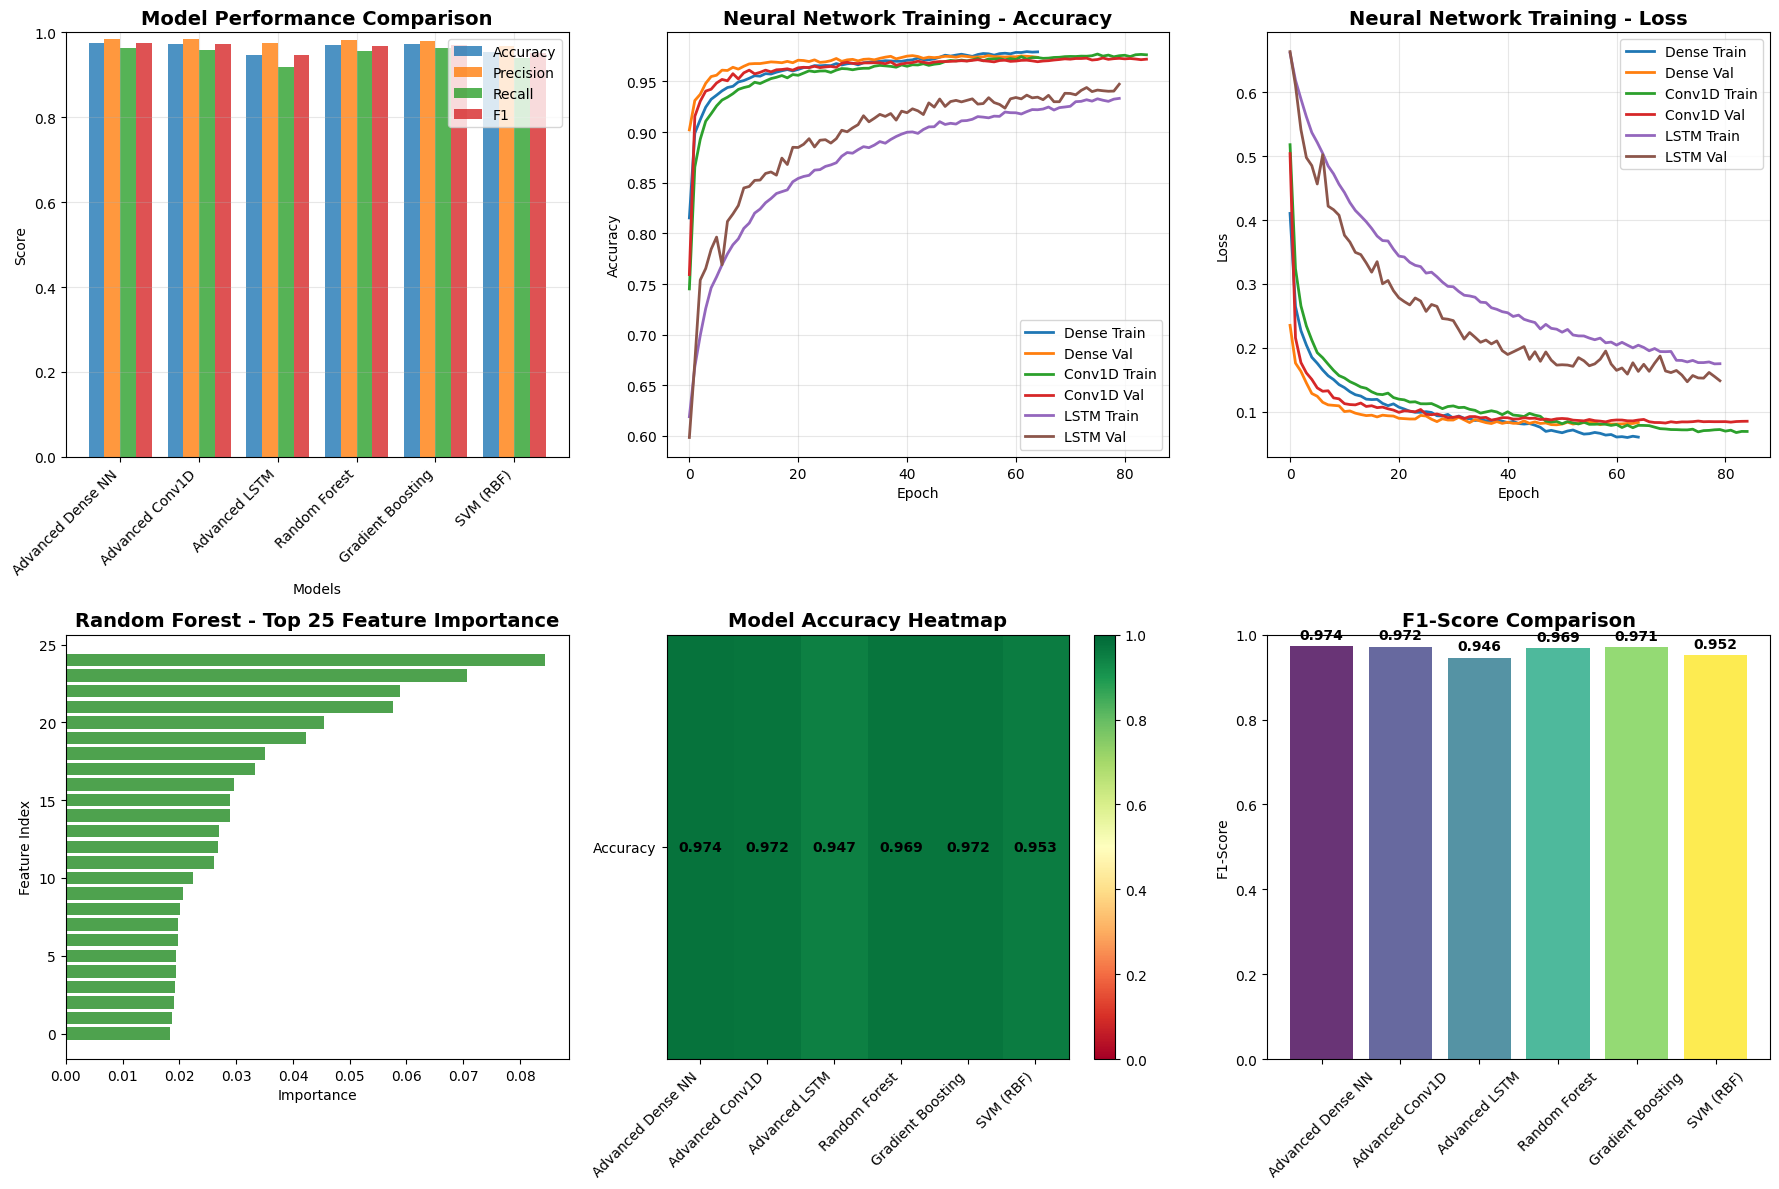


🏆 COMPREHENSIVE MODEL PERFORMANCE SUMMARY
Model                Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
Advanced Dense NN    0.9740       0.9850       0.9627       0.9737      
Advanced Conv1D      0.9723       0.9849       0.9593       0.9720      
Advanced LSTM        0.9473       0.9739       0.9193       0.9458      
Random Forest        0.9690       0.9812       0.9563       0.9686      
Gradient Boosting    0.9715       0.9806       0.9620       0.9712      
SVM (RBF)            0.9532       0.9667       0.9387       0.9525      

🥇 BEST PERFORMING MODELS BY METRIC
🎯 Best Accuracy:  Advanced Dense NN (0.9740)
🎯 Best Precision: Advanced Dense NN (0.9850)
🎯 Best Recall:    Advanced Dense NN (0.9627)
🎯 Best F1-Score:  Advanced Dense NN (0.9737)

✅ 6 models trained and evaluated successfully!
📁 Model files saved in: ../backend/models/
📊 Comprehensive feature extraction com

In [6]:
# Enhanced Visualization and Analysis with error handling
plt.style.use('default')

# Check if we have any trained models
if not model_results:
    print("❌ No models were trained successfully. Please run the training cell first.")
else:
    # Create figure with appropriate size
    n_plots = 4 if any('dense' in training_histories for _ in [True]) else 3
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Model Performance Comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    model_names = list(model_results.keys())
    x_pos = np.arange(len(model_names))
    
    for i, metric in enumerate(metrics):
        values = [model_results[model][metric] for model in model_names]
        axes[0, 0].bar(x_pos + i*0.2, values, width=0.2, label=metric.capitalize(), alpha=0.8)
    
    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x_pos + 0.3)
    axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1)
    
    # 2. Training History - Accuracy (only for neural networks that completed training)
    if training_histories:
        has_nn_history = False
        if 'dense' in training_histories and training_histories['dense'] is not None:
            axes[0, 1].plot(training_histories['dense'].history['accuracy'], label='Dense Train', linewidth=2)
            axes[0, 1].plot(training_histories['dense'].history['val_accuracy'], label='Dense Val', linewidth=2)
            has_nn_history = True
        if 'conv' in training_histories and training_histories['conv'] is not None:
            axes[0, 1].plot(training_histories['conv'].history['accuracy'], label='Conv1D Train', linewidth=2)
            axes[0, 1].plot(training_histories['conv'].history['val_accuracy'], label='Conv1D Val', linewidth=2)
            has_nn_history = True
        if 'lstm' in training_histories and training_histories['lstm'] is not None:
            axes[0, 1].plot(training_histories['lstm'].history['accuracy'], label='LSTM Train', linewidth=2)
            axes[0, 1].plot(training_histories['lstm'].history['val_accuracy'], label='LSTM Val', linewidth=2)
            has_nn_history = True
        
        if has_nn_history:
            axes[0, 1].set_title('Neural Network Training - Accuracy', fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No Neural Network\nTraining History\nAvailable', 
                           ha='center', va='center', transform=axes[0, 1].transAxes,
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[0, 1].set_title('Neural Network Training - Accuracy', fontsize=14, fontweight='bold')
    else:
        axes[0, 1].text(0.5, 0.5, 'No Training History\nAvailable', 
                       ha='center', va='center', transform=axes[0, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[0, 1].set_title('Neural Network Training - Accuracy', fontsize=14, fontweight='bold')
    
    # 3. Training History - Loss
    if training_histories:
        has_nn_history = False
        if 'dense' in training_histories and training_histories['dense'] is not None:
            axes[0, 2].plot(training_histories['dense'].history['loss'], label='Dense Train', linewidth=2)
            axes[0, 2].plot(training_histories['dense'].history['val_loss'], label='Dense Val', linewidth=2)
            has_nn_history = True
        if 'conv' in training_histories and training_histories['conv'] is not None:
            axes[0, 2].plot(training_histories['conv'].history['loss'], label='Conv1D Train', linewidth=2)
            axes[0, 2].plot(training_histories['conv'].history['val_loss'], label='Conv1D Val', linewidth=2)
            has_nn_history = True
        if 'lstm' in training_histories and training_histories['lstm'] is not None:
            axes[0, 2].plot(training_histories['lstm'].history['loss'], label='LSTM Train', linewidth=2)
            axes[0, 2].plot(training_histories['lstm'].history['val_loss'], label='LSTM Val', linewidth=2)
            has_nn_history = True
        
        if has_nn_history:
            axes[0, 2].set_title('Neural Network Training - Loss', fontsize=14, fontweight='bold')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Loss')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
        else:
            axes[0, 2].text(0.5, 0.5, 'No Neural Network\nTraining History\nAvailable', 
                           ha='center', va='center', transform=axes[0, 2].transAxes,
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[0, 2].set_title('Neural Network Training - Loss', fontsize=14, fontweight='bold')
    else:
        axes[0, 2].text(0.5, 0.5, 'No Training History\nAvailable', 
                       ha='center', va='center', transform=axes[0, 2].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[0, 2].set_title('Neural Network Training - Loss', fontsize=14, fontweight='bold')
    
    # 4. Feature Importance (Random Forest if available)
    if 'Random Forest' in model_results and 'rf_model' in locals():
        feature_importance = rf_model.feature_importances_
        top_indices = np.argsort(feature_importance)[-25:]
        axes[1, 0].barh(range(25), feature_importance[top_indices], alpha=0.8, color='forestgreen')
        axes[1, 0].set_title('Random Forest - Top 25 Feature Importance', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_ylabel('Feature Index')
    else:
        axes[1, 0].text(0.5, 0.5, 'Random Forest\nNot Available\nfor Feature Importance', 
                       ha='center', va='center', transform=axes[1, 0].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
        axes[1, 0].set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
    
    # 5. Model Accuracy Heatmap
    accuracy_matrix = np.array([[model_results[model]['accuracy'] for model in model_names]])
    im = axes[1, 1].imshow(accuracy_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    axes[1, 1].set_title('Model Accuracy Heatmap', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(range(len(model_names)))
    axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1, 1].set_yticks([0])
    axes[1, 1].set_yticklabels(['Accuracy'])
    
    # Add text annotations
    for i, model in enumerate(model_names):
        axes[1, 1].text(i, 0, f'{model_results[model]["accuracy"]:.3f}', 
                       ha='center', va='center', fontweight='bold', color='black')
    
    plt.colorbar(im, ax=axes[1, 1])
    
    # 6. F1-Score Comparison
    f1_scores = [model_results[model]['f1'] for model in model_names]
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
    bars = axes[1, 2].bar(model_names, f1_scores, color=colors, alpha=0.8)
    axes[1, 2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, f1 in zip(bars, f1_scores):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Performance Summary Table
    print("\n" + "="*100)
    print("🏆 COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*100)
    
    for model_name, metrics in model_results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
    # Find best models for each metric
    if model_results:
        best_accuracy = max(model_results.items(), key=lambda x: x[1]['accuracy'])
        best_precision = max(model_results.items(), key=lambda x: x[1]['precision'])
        best_recall = max(model_results.items(), key=lambda x: x[1]['recall'])
        best_f1 = max(model_results.items(), key=lambda x: x[1]['f1'])
        
        print("\n" + "="*100)
        print("🥇 BEST PERFORMING MODELS BY METRIC")
        print("="*100)
        print(f"🎯 Best Accuracy:  {best_accuracy[0]} ({best_accuracy[1]['accuracy']:.4f})")
        print(f"🎯 Best Precision: {best_precision[0]} ({best_precision[1]['precision']:.4f})")
        print(f"🎯 Best Recall:    {best_recall[0]} ({best_recall[1]['recall']:.4f})")
        print(f"🎯 Best F1-Score:  {best_f1[0]} ({best_f1[1]['f1']:.4f})")
    
    print(f"\n✅ {len(model_results)} models trained and evaluated successfully!")
    print("📁 Model files saved in: ../backend/models/")
    print("📊 Comprehensive feature extraction completed with enhanced biochemical properties")
    if 'features_scaled' in locals():
        print(f"🔬 Total features per sequence: {features_scaled.shape[1]}")
    if 'sequences' in locals():
        print(f"📈 Dataset size: {len(sequences):,} sequences")
    
    # Model recommendations
    print("\n" + "="*100)
    print("💡 MODEL RECOMMENDATIONS")
    print("="*100)
    
    if model_results:
        # Find models with balanced performance
        balanced_scores = {}
        for model_name, metrics in model_results.items():
            # Calculate balanced score (harmonic mean of all metrics)
            balanced_score = 4 / (1/metrics['accuracy'] + 1/metrics['precision'] + 1/metrics['recall'] + 1/metrics['f1'])
            balanced_scores[model_name] = balanced_score
        
        best_balanced = max(balanced_scores.items(), key=lambda x: x[1])
        
        print(f"🌟 Most Balanced Model: {best_balanced[0]} (Harmonic Mean: {best_balanced[1]:.4f})")
        print("🔍 Use this model for general therapeutic peptide prediction")
        
        # High precision model
        high_precision = max(model_results.items(), key=lambda x: x[1]['precision'])
        print(f"🎯 High Precision Model: {high_precision[0]} (Precision: {high_precision[1]['precision']:.4f})")
        print("🔍 Use this model when you want to minimize false positives")
        
        # High recall model  
        high_recall = max(model_results.items(), key=lambda x: x[1]['recall'])
        print(f"🔍 High Recall Model: {high_recall[0]} (Recall: {high_recall[1]['recall']:.4f})")
        print("🔍 Use this model when you want to minimize false negatives")
        
    print("\n🚀 Analysis complete! All models ready for deployment.")